In [36]:
import statsmodels.api as sm
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices                   # https://pypi.python.org/pypi/patsy
from patsy import dmatrix
from statsmodels.stats.api import anova_lm

#%matplotlib inline
%matplotlib notebook

## 3.6.1 Libraries

In [37]:
# Load data -- R: fix(Boston)
data = sm.datasets.get_rdataset("Boston", "MASS").data

## 3.6.2 Simple Linear Regression

In [38]:
# Column names -- R: names(Boston)
print data.columns.values

['crim' 'zn' 'indus' 'chas' 'nox' 'rm' 'age' 'dis' 'rad' 'tax' 'ptratio'
 'black' 'lstat' 'medv']


In [39]:
# Fit a OLS (Ordinary Least Square model) with medv as the response and lstat as the predictor
#      -- R: lm.fit = lm(medv∼lstat ,data=Boston)   , or
#      -- R: attach(Boston); lm.fit =lm(medv∼lstat ,data=Boston)
#
# y = b0 + b1 * x
#                <-- y: responses from training set, n values [506 X 1]
#                <-- x: predictors from training set.  These are the coefficient for b0, b1, ...  [506 X 2]

# USING PATSY
# Alternative: y = data['medv'];x = data['lstat'];x = sm.add_constant(x)   -- coefficient for b0, always 1
y,x = dmatrices('medv ~ lstat',data=data,return_type='dataframe')
model = sm.OLS(endog=y,exog=x)
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Sat, 27 Feb 2016   Prob (F-statistic):           5.08e-88
Time:                        12:13:37   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.000        33.448    35.659
lstat         -0.9500      0.039    -24.528      0.000        -1.026    -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# Model params -- R: coef(lm.fit)
print result.params

# Confidence interval of the fitted params -- R: confint (lm.fit)
print result.conf_int()

Intercept    34.553841
lstat        -0.950049
dtype: float64
                   0          1
Intercept  33.448457  35.659225
lstat      -1.026148  -0.873951


In [41]:
# Produce confidence intervals and prediction intervals for the prediction of medv for a given value of lstat.
# R: predict (lm.fit ,data.frame(lstat=c(5 ,10 ,15) ),interval ="prediction")
#
# Can I get this from StatsModel? The code below only give the predicion for medv, no confidence interval applied to it.
lstat_pred = pd.DataFrame({'intercept':[1,1,1],'lstat':[5,10,15]})
result.predict(lstat_pred)

array([ 29.80359411,  25.05334734,  20.30310057])

<IPython.core.display.Javascript object>


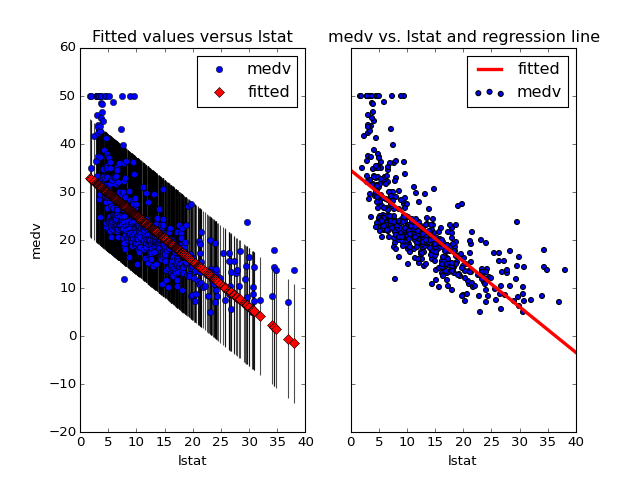

In [45]:
# Plot medv and lstat along with the least squares regression line using the plot() and abline() functions
# R: plot(lstat ,medv)
# R: abline (lm.fit)

fig, ax = plt.subplots(1,2,sharey=True,sharex=True)

# Stats Model plotting method
fig = sm.graphics.plot_fit(result, 1,ax=ax[0])

# I prefer this
sm.graphics.abline_plot(result.params[0],result.params[1],ax=ax[1],color='r',linewidth=3)
ax[1].scatter(data['lstat'],data['medv'])

plt.xlabel('lstat')
plt.title('medv vs. lstat and regression line')
plt.legend(['fitted','medv'])
plt.show()

##### Diagnostic plots (residuals) from par 3.3.3.

<IPython.core.display.Javascript object>


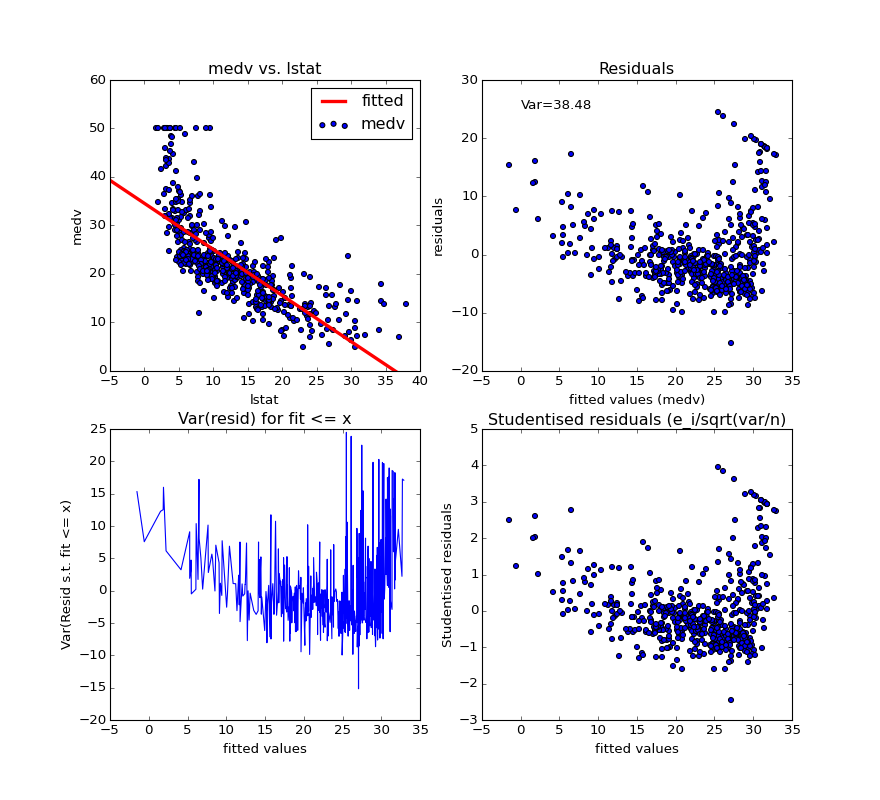

In [46]:
# I don't know what R would show at this point

fig, ax = plt.subplots(2,2,sharex=False)

fig.set_size_inches(11,10,forward=True)

# (1) medv vs. lstat
ax[0,0].scatter(data['lstat'],data['medv'])
sm.graphics.abline_plot(result.params[0],result.params[1],ax=ax[0,0],color='r',linewidth=3)
ax[0,0].set_xlabel('lstat')
ax[0,0].set_ylabel('medv')
ax[0,0].set_title('medv vs. lstat')
ax[0,0].legend(['fitted','medv'])

# (2) RESIDUALS
# notice the U-shape in the residuals --> non linearity
#
ax[0,1].scatter(result.fittedvalues,result.resid)
ax[0,1].set_xlabel('fitted values (medv)')
ax[0,1].set_ylabel('residuals')
ax[0,1].set_title('Residuals')
ax[0,1].text(0,25,'Var=%3.2f' % (np.var(result.resid)))

# (3) Non-constant variance. CUMULATIVE VARIANCE AS A FUNCTION OF LSTAT
# 
residuals=pd.DataFrame({'fitted values':result.fittedvalues,'resid':result.resid})
residuals_sort=residuals.sort(columns='fitted values')
residuals_sort.reset_index(inplace=True)
residuals_sort['var_incr'] = np.nan
for i in residuals_sort.index:
    residuals_sort.loc[i,'var_incr'] = np.var(residuals_sort.iloc[0:i]['resid'])
ax[1,0].plot(residuals_sort['fitted values'],residuals_sort['resid'])
ax[1,0].set_xlabel('fitted values')
ax[1,0].set_ylabel('Var(Resid s.t. fit <= x)')
ax[1,0].set_title('Var(resid) for fit <= x')

# (4) Outliers, STUDENTIZED RESIDUALS 
# e_i / STD_ERR <-- e_i / sqrt(var/n)
# 
residuals['studentised'] = result.get_influence().get_resid_studentized_external()
ax[1,1].scatter(residuals['fitted values'],residuals['studentised'])
ax[1,1].set_xlabel('fitted values')
ax[1,1].set_ylabel('Studentised residuals')
ax[1,1].set_title('Studentised residuals (e_i/sqrt(var/n)')

<IPython.core.display.Javascript object>


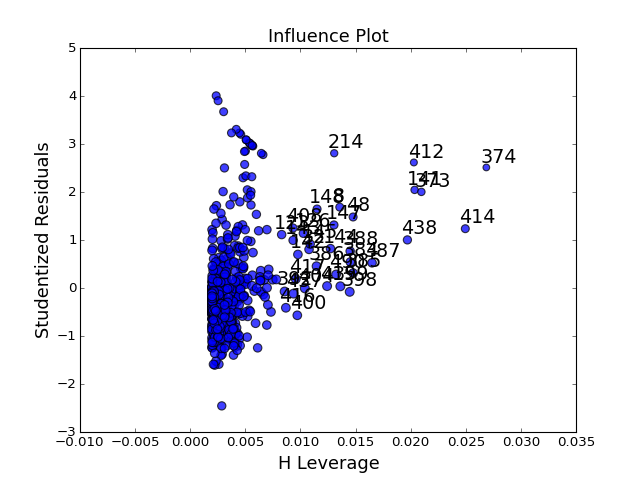

,dfb_Intercept,dfb_lstat,cooks_d,dffits,dffits_internal,hat_diag,standard_resid,student_resid
0,-0.059716,0.044977,0.001886,-0.061413,-0.061420,0.004263,-0.938750,-0.938639
1,-0.028156,0.015069,0.000582,-0.034110,-0.034128,0.002456,-0.687871,-0.687511
2,0.044083,-0.034510,0.001004,0.044789,0.044815,0.004864,0.641041,0.640666
3,0.019757,-0.016039,0.000198,0.019900,0.019918,0.005640,0.264480,0.264236
4,0.066762,-0.049471,0.002384,0.069065,0.069053,0.004059,1.081699,1.081882


In [47]:
# (5) High Leverage, STUDENTISED RESIDUALS VS. LEVERAGE
p=sm.graphics.influence_plot(result,size=6,alpha=1)
infl = result.get_influence()
response = infl.summary_frame()
response.head()

## 3.6.3 Multiple Linear Regression

In [48]:
# Fit a linear model with MEDV as the response and LSTAT, AGE as the predictors
y,x = dmatrices('medv ~ lstat + age',data=data,return_type='dataframe')
model = sm.OLS(endog=y,exog=x)
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Sat, 27 Feb 2016   Prob (F-statistic):           2.98e-88
Time:                        12:15:23   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     33.2228      0.731     45.458      0.000        31.787    34.659
lstat         -1.0321      0.048    -21.416      0.000        -1.127    -0.937
age            0.0345      0.012      2.826      0.005         0.011     0.059
==============================================================================
Omnibus:                      124.288   Durbin-Watson:                   0.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.026
Skew:                           1.362   Prob(JB):                     1.02e-53
Kurtosis:                       5.038   Cond. No.                         201.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# Fit a model using all available variables except the response
# R: lm.fit =lm(medv∼.,data=Boston)
formula = 'medv ~ ' + ' + '.join(data.columns- ['medv'])
y,x = dmatrices(formula,data=data,return_type='dataframe')
model = sm.OLS(endog=y,exog=x)
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sat, 27 Feb 2016   Prob (F-statistic):          6.72e-135
Time:                        12:15:24   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.000        26.432    46.487
age            0.0007      0.013      0.052      0.958        -0.025     0.027
black          0.0093      0.003      3.467      0.001         0.004     0.015
chas           2.6867      0.862      3.118      0.002         0.994     4.380
crim          -0.1080      0.033     -3.287      0.001        -0.173    -0.043
dis           -1.4756      0.199     -7.398      0.000        -1.867    -1.084
indus          0.0206      0.061      0.334      0.738        -0.100     0.141
lstat         -0.5248      0.051    -10.347      0.000        -0.624    -0.425
nox          -17.7666      3.820     -4.651      0.000       -25.272   -10.262
ptratio       -0.9527      0.131     -7.283      0.000        -1.210    -0.696
rad            0.3060      0.066      4.613      0.000         0.176     0.436
rm             3.8099      0.418      9.116      0.000         2.989     4.631
tax           -0.0123      0.004     -3.280      0.001        -0.020    -0.005
zn             0.0464      0.014      3.382      0.001         0.019     0.073
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                     1.51e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
# Car dataset - skipped

In [51]:
# AGE has a high p-value. Regression using all predictors except age.
formula = 'medv ~ ' + ' + '.join(data.columns- ['medv','age'])
y,x = dmatrices(formula,data=data,return_type='dataframe')
model = sm.OLS(endog=y,exog=x)
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     117.3
Date:                Sat, 27 Feb 2016   Prob (F-statistic):          6.08e-136
Time:                        12:15:25   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3024.
Df Residuals:                     493   BIC:                             3079.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     36.4369      5.080      7.172      0.000        26.456    46.418
black          0.0093      0.003      3.481      0.001         0.004     0.015
chas           2.6890      0.860      3.128      0.002         1.000     4.378
crim          -0.1080      0.033     -3.290      0.001        -0.173    -0.043
dis           -1.4786      0.191     -7.757      0.000        -1.853    -1.104
indus          0.0206      0.061      0.335      0.738        -0.100     0.141
lstat         -0.5239      0.048    -10.999      0.000        -0.617    -0.430
nox          -17.7135      3.679     -4.814      0.000       -24.943   -10.484
ptratio       -0.9522      0.130     -7.308      0.000        -1.208    -0.696
rad            0.3058      0.066      4.627      0.000         0.176     0.436
rm             3.8144      0.408      9.338      0.000         3.012     4.617
tax           -0.0123      0.004     -3.283      0.001        -0.020    -0.005
zn             0.0463      0.014      3.404      0.001         0.020     0.073
==============================================================================
Omnibus:                      178.343   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              786.386
Skew:                           1.523   Prob(JB):                    1.73e-171
Kurtosis:                       8.294   Cond. No.                     1.48e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 6.3.4 Interaction Terms

In [52]:
# Create a model with predictors LSTAT, AGE and add the interaction term between the two
# R: lm(formula = medv ∼ lstat * age , data = Boston )

formula = 'medv ~ age + lstat + age:lstat' # equiv to: 'medv ~  age * lstat'
y,x = dmatrices(formula,data=data,return_type='dataframe')
model = sm.OLS(endog=y,exog=x)
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Sat, 27 Feb 2016   Prob (F-statistic):           4.86e-88
Time:                        12:15:27   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     36.0885      1.470     24.553      0.000        33.201    38.976
age           -0.0007      0.020     -0.036      0.971        -0.040     0.038
lstat         -1.3921      0.167     -8.313      0.000        -1.721    -1.063
age:lstat      0.0042      0.002      2.244      0.025         0.001     0.008
==============================================================================
Omnibus:                      135.601   Durbin-Watson:                   0.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              296.955
Skew:                           1.417   Prob(JB):                     3.29e-65
Kurtosis:                       5.461   Cond. No.                     6.88e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 3.6.5 Non-linear Transformations of the Predictors

In [53]:
# Given a predictor X, create a predictor X^2
# R: lm.fit2=lm(medv∼lstat +I(lstat ^2))
formula = 'medv ~ lstat + np.power(lstat,2)'
y,x = dmatrices(formula,data=data,return_type='dataframe')
model = sm.OLS(endog=y,exog=x)
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Sat, 27 Feb 2016   Prob (F-statistic):          1.56e-112
Time:                        12:15:28   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             42.8620      0.872     49.149      0.000        41.149    44.575
lstat                 -2.3328      0.124    -18.843      0.000        -2.576    -2.090
np.power(lstat, 2)     0.0435      0.004     11.628      0.000         0.036     0.051
==============================================================================
Omnibus:                      107.006   Durbin-Watson:                   0.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.388
Skew:                           1.128   Prob(JB):                     2.55e-50
Kurtosis:                       5.397   Cond. No.                     1.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
# Use the anova() function to quantify the extent to which the quadratic fit is superior to the linear fit.
# R: anova(lm.fit ,lm.fit2)
from statsmodels.stats.api import anova_lm
#
y1,x1 = dmatrices('medv ~ lstat',data=data,return_type='dataframe')
y2,x2 = dmatrices('medv ~ lstat + np.power(lstat,2)',data=data,return_type='dataframe')
result1 = sm.OLS(endog=y1,exog=x1).fit()
result2 = sm.OLS(endog=y2,exog=x2).fit()

t = anova_lm(result1,result2)
print(t)
# The anova() function performs a hypothesis test comparing the two models. The null hypothesis is that the two models
# fit the data equally well, and the alternative hypothesis is that the full model is superior. 
# Here the F-statistic is 135 and the associated p-value is virtually zero. This provides very clear evidence that
# the model containing the predictors lstat and lstat^2 is far superior to the model that only contains the predictor lstat.
# This is not surprising, since earlier we saw evidence for non-linearity in the relationship between medv and lstat

   df_resid           ssr  df_diff     ss_diff           F        Pr(>F)
0       504  19472.381418        0         NaN         NaN           NaN
1       503  15347.243158        1  4125.13826  135.199822  7.630116e-28


<IPython.core.display.Javascript object>


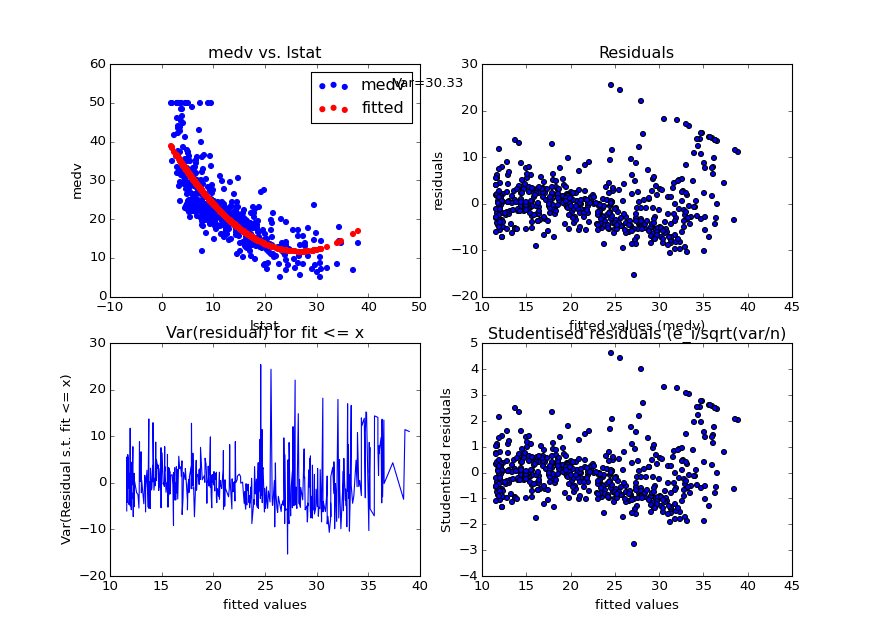

In [55]:
# Diagnostic plots to confirm that there is no evident pattern left in the data
fig, ax = plt.subplots(2,2)
fig.set_size_inches(11,8,forward=True)

# medv vs. lstat
ax[0,0].scatter(data['lstat'],data['medv'],color='b',label='medv')
ax[0,0].scatter(data['lstat'],result.fittedvalues,color='r',label='fitted')
ax[0,0].set_xlabel('lstat')
ax[0,0].set_ylabel('medv')
ax[0,0].set_title('medv vs. lstat')
ax[0,0].legend()

# RESIDUALS
# notice the U-shape in the residuals --> non linearity
#
ax[0,1].scatter(result.fittedvalues,result.resid)
ax[0,1].set_xlabel('fitted values (medv)')
ax[0,1].set_ylabel('residuals')
ax[0,1].set_title('Residuals')
ax[0,1].text(0,25,'Var=%3.2f' % (np.var(result.resid)))

# (3) Non-constant variance, CUMULATIVE VARIANCE AS A FUNCTION OF LSTAT
# 
residuals=pd.DataFrame({'fitted values':result.fittedvalues,'resid':result.resid})
residuals_sort=residuals.sort(columns='fitted values')
residuals_sort.reset_index(inplace=True)
residuals_sort['var_incr'] = np.nan
for i in residuals_sort.index:
    residuals_sort.loc[i,'var_incr'] = np.var(residuals_sort.iloc[0:i]['resid'])
ax[1,0].plot(residuals_sort['fitted values'],residuals_sort['resid'])
ax[1,0].set_xlabel('fitted values')
ax[1,0].set_ylabel('Var(Residual s.t. fit <= x)')
ax[1,0].set_title('Var(residual) for fit <= x')

# (4) Outliers, STUDENTIZED RESIDUALS 
# e_i / STD_ERR <-- e_i / sqrt(var/n)
# 
residuals['studentised'] = result.get_influence().get_resid_studentized_external()
ax[1,1].scatter(residuals['fitted values'],residuals['studentised'])
ax[1,1].set_xlabel('fitted values')
ax[1,1].set_ylabel('Studentised residuals')
ax[1,1].set_title('Studentised residuals (e_i/sqrt(var/n)')

In [56]:
# Use the poly() function to create a polynomial up to the 5th order to be used in lm().
#   R: lm.fit5=lm(medv∼poly(lstat ,5))
#
# Not sure this can be done with Patsy - but string manipulation in Python can help
formula = 'medv ~ lstat'
for i in range(2,6): formula = formula + ' + np.power(lstat,%d)' % i
y,x = dmatrices(formula,data=data,return_type='dataframe')

model = sm.OLS(endog=y,exog=x)
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     214.2
Date:                Sat, 27 Feb 2016   Prob (F-statistic):          8.73e-122
Time:                        12:15:39   Log-Likelihood:                -1550.6
No. Observations:                 506   AIC:                             3113.
Df Residuals:                     500   BIC:                             3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             67.6997      3.604     18.783      0.000        60.618    74.781
lstat                -11.9911      1.526     -7.859      0.000       -14.989    -8.994
np.power(lstat, 2)     1.2728      0.223      5.703      0.000         0.834     1.711
np.power(lstat, 3)    -0.0683      0.014     -4.747      0.000        -0.097    -0.040
np.power(lstat, 4)     0.0017      0.000      4.143      0.000         0.001     0.003
np.power(lstat, 5) -1.632e-05   4.42e-06     -3.692      0.000      -2.5e-05 -7.63e-06
==============================================================================
Omnibus:                      144.085   Durbin-Watson:                   0.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              494.545
Skew:                           1.292   Prob(JB):                    4.08e-108
Kurtosis:                       7.096   Cond. No.                     1.37e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>


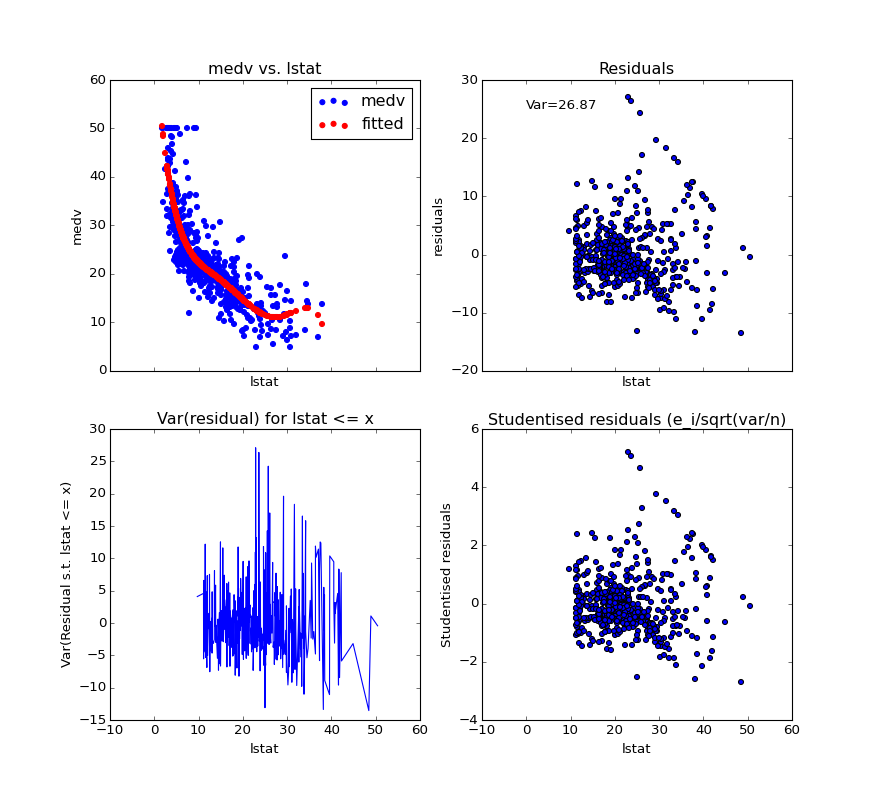

In [57]:
# Diagnostic plots - let's see how the prediction looks like now
# I am not convinced by the 5th order term

fig, ax = plt.subplots(2,2,sharex=True)

fig.set_size_inches(11,10,forward=True)

# medv vs. lstat
ax[0,0].scatter(data['lstat'],data['medv'],color='b',label='medv')
ax[0,0].scatter(data['lstat'],result.fittedvalues,color='r',label='fitted')
ax[0,0].set_xlabel('lstat')
ax[0,0].set_ylabel('medv')
ax[0,0].set_title('medv vs. lstat')
ax[0,0].legend()

# RESIDUALS
# notice the U-shape in the residuals --> non linearity
#
ax[0,1].scatter(result.fittedvalues,result.resid)
ax[0,1].set_xlabel('lstat')
ax[0,1].set_ylabel('residuals')
ax[0,1].set_title('Residuals')
ax[0,1].text(0,25,'Var=%3.2f' % (np.var(result.resid)))

# (3) Non-constant variance, CUMULATIVE VARIANCE AS A FUNCTION OF LSTAT
# 
residuals=pd.DataFrame({'lstat':result.fittedvalues,'resid':result.resid})
residuals_sort=residuals.sort(columns='lstat')
residuals_sort.reset_index(inplace=True)
residuals_sort['var_incr'] = np.nan
for i in residuals_sort.index:
    residuals_sort.loc[i,'var_incr'] = np.var(residuals_sort.iloc[0:i]['resid'])
ax[1,0].plot(residuals_sort['lstat'],residuals_sort['resid'])
ax[1,0].set_xlabel('lstat')
ax[1,0].set_ylabel('Var(Residual s.t. lstat <= x)')
ax[1,0].set_title('Var(residual) for lstat <= x')

# (4) Outliers, STUDENTIZED RESIDUALS 
# e_i / STD_ERR <-- e_i / sqrt(var/n)
# 
residuals['studentised'] = result.get_influence().get_resid_studentized_external()
ax[1,1].scatter(residuals['lstat'],residuals['studentised'])
ax[1,1].set_xlabel('lstat')
ax[1,1].set_ylabel('Studentised residuals')
ax[1,1].set_title('Studentised residuals (e_i/sqrt(var/n)')

## 3.6.6 Qualitative Predictors

### Load the CARSEATS data from the ISLR library
#### Skipped - dataset not available


In [58]:
# Examine the Carseats data
data = pd.read_csv(u"C:/Users\Alessandro\Documents\projects\ISL\data\Carseats.data",index_col=0)
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
5,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [59]:
# Given a qualitative variable such as Shelveloc, R (and Patsy) generates dummy variables. Also include some interaction terms.
#
# R: lm.fit =lm(Sales∼.+ Income :Advertising +Price :Age ,data=Carseats )
formula = 'Sales ~ ' + ' + '.join(data.columns - ['Sales']) + ' + Income:Advertising + Price:Age'
y,x = dmatrices(formula,data=data,return_type='dataframe')

model = sm.OLS(endog=y,exog=x)
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Sat, 27 Feb 2016   Prob (F-statistic):          6.14e-166
Time:                        12:15:57   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               6.5756      1.009      6.519      0.000         4.592     8.559
ShelveLoc[T.Good]       4.8487      0.153     31.724      0.000         4.548     5.149
ShelveLoc[T.Medium]     1.9533      0.126     15.531      0.000         1.706     2.201
US[T.Yes]              -0.1576      0.149     -1.058      0.291        -0.450     0.135
Urban[T.Yes]            0.1402      0.112      1.247      0.213        -0.081     0.361
Advertising             0.0702      0.023      3.107      0.002         0.026     0.115
Age                    -0.0579      0.016     -3.633      0.000        -0.089    -0.027
CompPrice               0.0929      0.004     22.567      0.000         0.085     0.101
Education              -0.0209      0.020     -1.063      0.288        -0.059     0.018
Income                  0.0109      0.003      4.183      0.000         0.006     0.016
Population              0.0002      0.000      0.433      0.665        -0.001     0.001
Price                  -0.1008      0.007    -13.549      0.000        -0.115    -0.086
Income:Advertising      0.0008      0.000      2.698      0.007         0.000     0.001
Price:Age               0.0001      0.000      0.801      0.424        -0.000     0.000
==============================================================================
Omnibus:                        1.281   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.147
Skew:                           0.129   Prob(JB):                        0.564
Kurtosis:                       3.050   Cond. No.                     1.31e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""